In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns

!pip install -U -q PyDrive
!pip install scikit-plot
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id':'1q1Ha1e9K9VJD8nCeggB8VKD4jN9UJaIN'}) # replace the id with id of file you want to access
downloaded.GetContentFile('IADSED.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


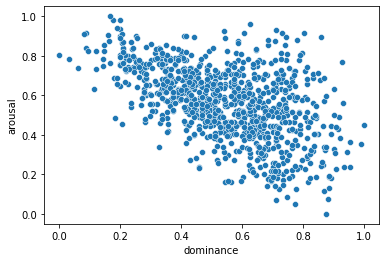

In [ ]:
sound = pd.read_csv('IADSED.csv')
df = pd.DataFrame(sound)
nullCount = df.columns[df.isnull().any()]
# All the columns that have missing data are numeric, so I'm using the mean to fill the null values
df.fillna(df.mean(), inplace=True)
df_num = df.drop(df.loc[:, 'source':'BE_Classification'].columns, axis=1, inplace=False)
df.head()

# normalize the data attributes
scaler = MinMaxScaler()
scaledDf = pd.DataFrame(scaler.fit_transform(df_num),index=df_num.index, columns=df_num.columns, ) 

#fig, axs = plt.subplots(ncols=3,figsize=(90,20))
sns.scatterplot(data=scaledDf, x='dominance', y='arousal')


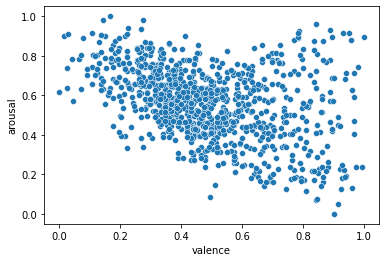

In [ ]:
sns.scatterplot(data=scaledDf, x='valence', y='arousal')


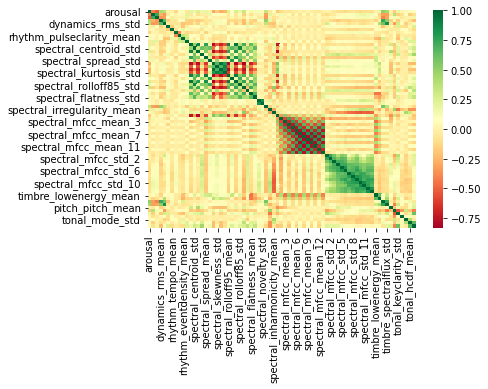

In [ ]:
sns.heatmap(scaledDf.corr(),cmap='RdYlGn')

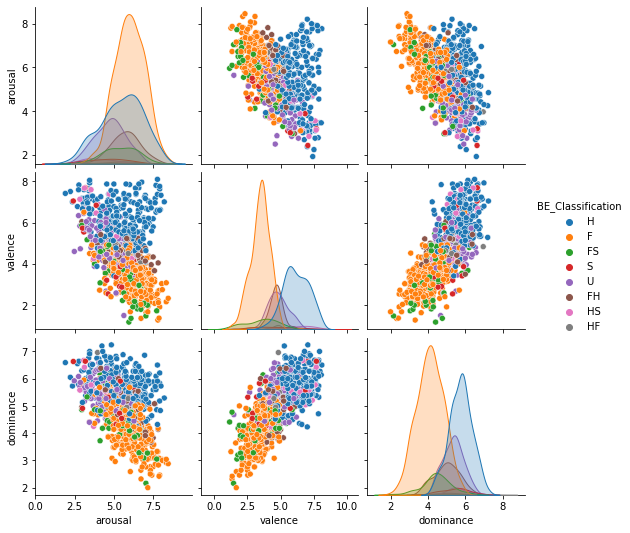

In [ ]:
dfPair = df.iloc[:, 4:8]
dfPair.head()
sns.pairplot(dfPair, hue="BE_Classification") 

In [ ]:
df1 = scaledDf[["arousal","dynamics_rms_mean"]]
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm')

,arousal,dynamics_rms_mean
arousal,1.000000,0.430811
dynamics_rms_mean,0.430811,1.000000


In [ ]:
# Splitting the dataset into training and testing data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
X = scaledDf.iloc[:,scaledDf.columns != 'dominance'].values # these are factors for the prediction
X = scaledDf[['arousal', 'valence', 'dynamics_rms_mean', 'spectral_centroid_std',
       'spectral_skewness_mean', 'spectral_irregularity_mean',
       'spectral_inharmonicity_mean', 'spectral_mfcc_mean_1',
       'spectral_mfcc_mean_4', 'tonal_hcdf_std']].values
# X = scaledDf[['arousal', 'valence', 'dynamics_rms_std', 'rhythm_attacktime_mean',
#        'rhythm_eventdensity_mean', 'rhythm_fluctuationmax_peakposmean']].values
#X = scaledDf.iloc[:, [0] + [1] + list(range(3,71)) ].values
# X = scaledDf[['arousal', 'valence', 'dynamics_rms_std', 'rhythm_attacktime_mean',
#        'rhythm_tempo_mean', 'rhythm_tempo_std', 'rhythm_pulseclarity_mean',
#        'rhythm_eventdensity_mean', 'rhythm_fluctuationmax_peakposmean']].values
y = scaledDf.iloc[:,2].values # this is what we want to predict

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=34)

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=10)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
# X_train, X_test, fs = select_features(X_train, y_train, X_test)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import numpy as np
lr_model = LinearRegression()
lr_model.fit(X_train, y_train.ravel())
lr_model_train = lr_model.predict(X_train)
print(metrics.mean_squared_error(y_train, lr_model_train, squared=False)) #squared = False returns RMSE
lr_model_test = lr_model.predict(X_test)
print(metrics.mean_squared_error(y_test, lr_model_test, squared=False))

0.10370609686118534
0.10248546309456624


In [ ]:
svrPoly = SVR(kernel="poly", C = 1, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svrPoly.fit(X_train, y_train.ravel())
svr_model_train = svrPoly.predict(X_train)
print(metrics.mean_squared_error(y_train, svr_model_train, squared=False)) #squared = False returns RMSE
svr_model_test = svrPoly.predict(X_test)
print(metrics.mean_squared_error(y_test, svr_model_test, squared=False))


0.10007276200124203
0.10126961883392674


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index]
  svrPoly.fit(X_train, y_train)
  y_train_data_pred = svrPoly.predict(X_train)
  y_test_data_pred = svrPoly.predict(X_test)
  fold_training_error = metrics.mean_squared_error(y_train, y_train_data_pred,squared=False)
  fold_testing_error = metrics.mean_squared_error(y_test, y_test_data_pred,squared=False)
  list_training_error.append(fold_training_error)
  list_testing_error.append(fold_testing_error)

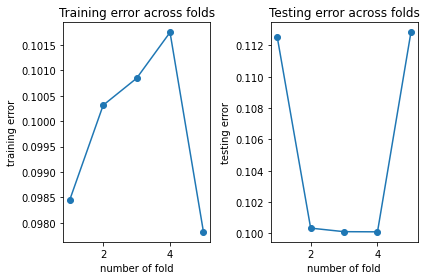

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
plt.xlabel('number of fold') 
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel("testing error")
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

In [ ]:
kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index]
  lr_model.fit(X_train, y_train)
  y_train_data_pred = lr_model.predict(X_train)
  y_test_data_pred = lr_model.predict(X_test)
  fold_training_error = metrics.mean_squared_error(y_train, y_train_data_pred,squared=False)
  fold_testing_error = metrics.mean_squared_error(y_test, y_test_data_pred,squared=False)
  list_training_error.append(fold_training_error)
  list_testing_error.append(fold_testing_error)

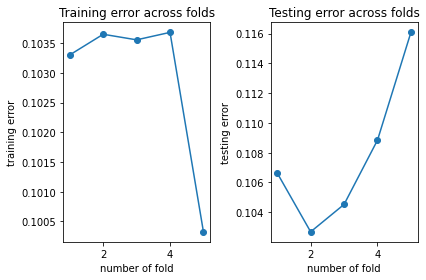

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
plt.xlabel('number of fold') 
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel("testing error")
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

In [ ]:
# 5 fold Cross Validation

scores_arou_lr = cross_val_score(lr_model, X_test, y_test, cv=5)
scores_arou_poly = cross_val_score(svrPoly, X_test, y_test, cv=5)
print("%0.3f accuracy for Linear Regression with a standard deviation of %0.3f" % (scores_arou_lr.mean(), scores_arou_lr.std()))
print("%0.3f accuracy for Support Vector Regression with a standard deviation of %0.3f" % (scores_arou_poly.mean(), scores_arou_poly.std()))

0.600 accuracy for Linear Regression with a standard deviation of 0.126
0.617 accuracy for Support Vector Regression with a standard deviation of 0.094


In [ ]:
# import sklearn.externals as extjoblib
# import joblib
# from sklearn.feature_selection import SequentialFeatureSelector as sfs
# from sklearn.linear_model import LinearRegression

# lreg = LinearRegression()
  
# sfs1 = sfs(lreg, n_features_to_select=10, direction='backward')
# sfs1 = sfs1.fit(X, y)
# indices = sfs1.get_support(indices=True)

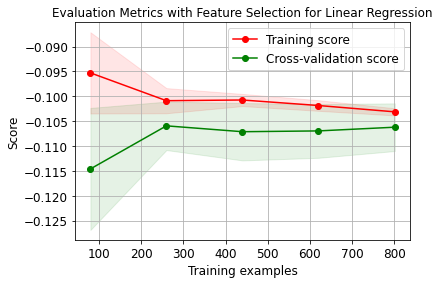

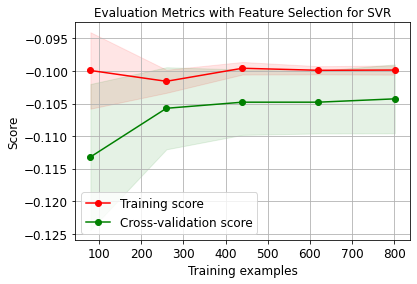

In [ ]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr_model, X, y,
                                     cv=7, shuffle=True,n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large", scoring='neg_root_mean_squared_error',
                                     title="Evaluation Metrics with Feature Selection for Linear Regression");
skplt.estimators.plot_learning_curve(svrPoly, X, y,
                                     cv=7, shuffle=True,n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large", scoring='neg_root_mean_squared_error',
                                     title="Evaluation Metrics with Feature Selection for SVR");

In [ ]:
cat /proc/meminfo | numfmt --field 2 --from-unit=Ki --to-unit=Mi | sed 's/ kB/M/g'

MemTotal:          12986M
MemFree:            8938M
MemAvailable:      10997M
Buffers:              86M
Cached:             1869M
SwapCached:            0M
Active:              586M
Inactive:           3251M
Active(anon):          2M
Inactive(anon):     1585M
Active(file):        585M
Inactive(file):     1667M
Unevictable:           0M
Mlocked:               0M
SwapTotal:             0M
SwapFree:              0M
Dirty:                 2M
Writeback:             0M
AnonPages:          1882M
Mapped:              313M
Shmem:                 2M
KReclaimable:         90M
Slab:                122M
SReclaimable:         90M
SUnreclaim:           33M
KernelStack:           5M
PageTables:           38M
NFS_Unstable:          0M
Bounce:                0M
WritebackTmp:          0M
CommitLimit:        6493M
Committed_AS:       3808M
VmallocTotal:      33554432M
VmallocUsed:          10M
VmallocChunk:          0M
Percpu:                2M
HardwareCorrupted:     0M
AnonHugePages:         0M
ShmemHuge

In [ ]:
X_names = scaledDf.loc[:, scaledDf.columns!='dominance']
X_names.columns[indices]

Index(['arousal', 'valence', 'dynamics_rms_mean', 'dynamics_rms_std',
       'rhythm_tempo_std', 'spectral_centroid_mean',
       'spectral_brightness_mean', 'spectral_brightness_std',
       'spectral_spread_std', 'spectral_skewness_mean'],
      dtype='object')